# Data Mining and Visualization-Part 2
In this second part of the project, you are requested to create a classification model that will be
used by the marketing managers of the insurance company to decide which new potential customers
to contact.

In [1]:
# for inline plots in jupyter
%matplotlib inline 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.tree import export_graphviz
from IPython.display import Image  
import pydotplus

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold 

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
 

from sklearn.naive_bayes import GaussianNB 
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier,Pool
from sklearn.ensemble import BaggingClassifier

from scipy import stats 
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, accuracy_score






In [4]:
train = pd.read_csv("./marketing_campaigns_train_final_part1.csv")
valid = pd.read_csv("./marketing_campaigns_validation_final_part1.csv")
train.columns

Index(['id ', 'status', 'education', 'profession', 'device', 'loan',
       'mortgage', 'credit', 'positive', 'subscribed', 'p_participant',
       'l_season', 'debts', 'age_z_norm', 'account_balance_z_norm',
       'n_contact_z_norm', 'l_call_duration_z_norm', 'n_p_contact_z_norm',
       'p_days_z_norm', 'l_day_z_norm', 'l_season_z_norm', 'debts_z_norm',
       'l_day_bin', 'account_balance_bin', 'age_bin', 'n_contact_bin',
       'l_call_duration_bin'],
      dtype='object')

#### train_test_split on the valid data 

we will run models on the valid data we created so we need to split the data to train and test as we did for the test data

In [5]:
X_valid = valid.drop(['subscribed'], axis=1)
y_valid = valid['subscribed']

we will keep all the different types of the data in a dictionary data_option_dict, the keys are the names of the data and the values are the data

In [6]:
data_option_dict = {}

when we find the best type of data for each midel and its hyper parameters we will run a model evaluation (we wull run the wanted model with the wanted data on number of foldes) and we will store the accuracy of each fold in a dictionary model_option_dict 

In [7]:
model_option_dict = {}

# split the data to 5 types of data
we will make 5 options of data and later we will choose the best option of the data to each classifier
now we will describe everyone of the options in which we will split the data (train) to

* __data option 1: data_cat_no_debts__ <br>
all the data is in categories (discrete) <br>
the columns are: <br>
'status', 'profession', 'device', 'loan', 'mortgage', 'credit', 'positive', 'p_participant', 'subscribed', 'l_season', 'l_call_duration', 'l_day_bin', 'account_balance_bin', 'age_bin', 'n_contact_bin'

In [8]:
data_cat_no_debts = train[[ 'status', 'profession', 'device', 'loan', 'mortgage', 'credit', 'positive', 'p_participant',
        'subscribed', 'l_season', 'l_call_duration_bin', 'l_day_bin', 'account_balance_bin', 'age_bin', 'n_contact_bin']].copy()

valid_cat_no_debts = valid[[ 'status', 'profession', 'device', 'loan', 'mortgage', 'credit', 'positive', 'p_participant',
        'subscribed', 'l_season', 'l_call_duration_bin', 'l_day_bin', 'account_balance_bin', 'age_bin', 'n_contact_bin']].copy()

In [9]:
data_option_dict['data_cat_no_debts'] = data_cat_no_debts

* __data option 2: data_norm_and_not_with_debts__ <br>
data with also normalized and not nomalized columns. <br>
the columns are: <br>
'status', 'profession', 'device', 'debts', 'p_participant', 'subscribed', 'l_season', 'l_call_duration_z_norm', 
'account_balance_z_norm', 'n_contact_z_norm', 'l_day_z_norm'

In [10]:
data_norm_and_not_with_debts = train[['status', 'profession', 'device', 'debts', 'p_participant', 'subscribed', 'l_season', 
                                   'l_call_duration_z_norm', 'account_balance_z_norm', 'n_contact_z_norm', 'age_z_norm', 'l_day_z_norm']].copy()

valid_norm_and_not_with_debts = valid[['status', 'profession', 'device', 'debts', 'p_participant', 'subscribed', 'l_season', 
                                   'l_call_duration_z_norm', 'account_balance_z_norm', 'n_contact_z_norm', 'age_z_norm', 'l_day_z_norm']].copy()

In [11]:
data_option_dict['data_norm_and_not_with_debts'] = data_norm_and_not_with_debts

* __data option 3: data_cat_with_debts__ <br>
the data is the data from option 1, but now instead of using the columns 'loan', 'mortgage', 'credit' and 'positive', we will only use the column 'debts'. <br>
the columns are: <br>
'status', 'profession', 'device', 'debts', 'p_participant', 'subscribed', 'l_season', 'l_call_duration', 'l_day_bin', 'account_balance_bin', 'age_bin', 'n_contact_bin'

In [12]:
data_cat_with_debts = train[['status', 'profession', 'device', 'debts', 'p_participant', 'subscribed', 'l_season', 
                              'l_call_duration_bin', 'l_day_bin', 'account_balance_bin', 'age_bin', 'n_contact_bin']].copy()
valid_cat_with_debts = valid[['status', 'profession', 'device', 'debts', 'p_participant', 'subscribed', 'l_season', 
                              'l_call_duration_bin', 'l_day_bin', 'account_balance_bin', 'age_bin', 'n_contact_bin']].copy()

In [13]:
data_option_dict['data_cat_with_debts'] = data_cat_with_debts

* __data option 4: data_cat_no_debts_dummies__ <br>
the data is the data from option 1, but now we will also create dummies for every one of the columns.

In [14]:
# function to divide the data into dummies
def divide_to_dummies(data):
    dummies_col = [col for col in data if len(data[col].unique()) > 2 and len(train[col].unique()) < 13]
    data_dummies = pd.get_dummies(data = data, columns = dummies_col )
    return data_dummies

In [15]:
data_cat_no_debts_dummies = divide_to_dummies(data_cat_no_debts.copy())
valid_cat_no_debts_dummies = divide_to_dummies(valid_cat_no_debts.copy())

In [16]:
data_option_dict['data_cat_no_debts_dummies'] = data_cat_no_debts_dummies

* __data option 5: data_cat_with_debts_dummies__ <br>
the data is the data from option 3, but now we will also create dummies for every one of the columns.

In [17]:
data_cat_with_debts_dummies = divide_to_dummies(data_cat_with_debts.copy())
valid_cat_with_debts_dummies = divide_to_dummies(valid_cat_with_debts.copy())

In [18]:
data_option_dict['data_cat_with_debts_dummies'] = data_cat_with_debts_dummies

In [19]:
X = data_cat_with_debts.drop(['subscribed'], axis=1)
y = data_cat_with_debts['subscribed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

In [20]:
clf_list = []

### data evaluation 

we will use this function in order to evaluate a spesific given classifier with different types of data. <br> 
* input: data_dict - a dictionary in which are all the different types of the data, the keys are the names of the data and the   values are the data itself. <br>
  clf - the name classifier for which we want to find the best type of data 
* output: cm_dict - dictionary of confussion matrix for each of the data types, <br>
  acc_dict - dictionary of accurasy values for each of the data types, <br>
  prec_dict - dictionary of precision values for each of the data types

In [21]:
def data_cv(data_dict, clf):
    cm_dict, acc_dict,prec_dict = {}, {},{}
    #auc_dict={}
    kf = KFold(n_splits=5, shuffle=True, random_state=42) #for cross validation

    for data in data_dict.keys():
        X = data_dict[data].drop(['subscribed'], axis = 1)
        y = data_dict[data]['subscribed']
        X = X.to_numpy()
        #print("\n","------",data,"------")
        for train_index, test_index in kf.split(X):
            # split to train and test
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y.to_numpy()[train_index], y.to_numpy()[test_index]
            # train the model and make a prediction
            if clf.__class__.__name__=='CatBoostClassifier()':
                col_cat = [col for col in X_train.columns if (col.find('z_norm') == -1)]
                clf.fit(X_train, y_train,cat_features=col_cat)
            else:
                clf.fit(X_train, y_train)
            y_pred_best = clf.predict(X_test)
            cm=metrics.confusion_matrix(y_test, y_pred_best)
            acc = (cm[0][0]+cm[1][1])/sum(sum(cm))
            #print('classification_report\n',metrics.classification_report(y_test,y_pred_best))
            prec=cm[1][1]/(cm[1][1]+cm[0][1])
            # save the results
            cm_list = cm_dict.get(data,[])
            cm_list.append(cm)
            cm_dict[data] = cm_list

            acc_list = acc_dict.get(data,[])
            acc_list.append(acc)
            acc_dict[data] = acc_list

            prec_list = prec_dict.get(data,[])
            prec_list.append(prec)
            prec_dict[data] = prec_list

            #print("Accuracy: ", acc)
            #print("precision: ",prec)
            #print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

    return  cm_dict, acc_dict,prec_dict
    
    
    

for each classifier we will compare between different types of data which are stored in a dictionary. we will run the data_cv function with the default classifier (without finding the best parameters),
after we find the accurasy values of this classifier with everyone of the data types, we will use a ttest to find the best type of data for each of the classifiers


### Model Evaluation

after we found the best type of data for a given classifier we want to run a model evaluation with a classifier and its best data. we will keep a list of accuracy for everyone of the folds for each algorithm and its data

In [22]:
def mod_cv(clf, X, y):
    cm_dict, acc_dict,prec_dict = {}, {},{}
    X = X.to_numpy()
    kf = KFold(n_splits=5, shuffle=True, random_state=42) #for cross validation
    k = 0
    for train_index, test_index in kf.split(X):
        #print("train_index", train_index)
        #print("test_index", test_index)
        k+=1
        print("------",k,"------")
        # split to train and test
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y.to_numpy()[test_index]
        #print("y", y)
        #print("train_index", train_index)

        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        cm = metrics.confusion_matrix(y_test, y_pred)
        acc = (cm[0][0]+cm[1][1])/sum(sum(cm))
        prec=cm[1][1]/(cm[1][1]+cm[0][1])
        
        cm_list = cm_dict.get(clf.__class__.__name__,[])
        cm_list.append(cm)
        cm_dict[clf.__class__.__name__] = cm_list

        acc_list = acc_dict.get(clf.__class__.__name__,[])
        acc_list.append(acc)
        acc_dict[clf.__class__.__name__] = acc_list

        prec_list = prec_dict.get(clf.__class__.__name__,[])
        prec_list.append(prec)
        prec_dict[clf.__class__.__name__] = prec_list

        #print("Classifier: ", clf)
        print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))
    return  cm_dict, acc_dict,prec_dict




### ROC curve

In [23]:
def roc_curve(clf,X_test,y_test,X_valid,y_valid):
    
    y_pred_train = clf.predict(X_test)
    cm_train = metrics.confusion_matrix(y_test, y_pred_train)
    acc_train = (cm_train[0][0]+cm_train[1][1])/sum(sum(cm_train))
    prec_train=cm_train[1][1]/(cm_train[1][1]+cm_train[0][1])
    print('train:\n','accuracy:',acc_train,'\n precision:',prec_train)
    print('cm:\n',pd.DataFrame(cm_train))

    

    y_probs_train = clf.predict_proba(X_test) # probability prediction
    fpr_train, tpr_train, _ = metrics.roc_curve(y_test, y_probs_train[:,1])
    auc_train = metrics.auc(fpr_train, tpr_train)
    
   
    y_pred_valid = clf.predict(X_valid)
    cm_valid= metrics.confusion_matrix(y_valid, y_pred_valid)
    acc_valid = (cm_valid[0][0]+cm_valid[1][1])/sum(sum(cm_valid))
    prec_valid=cm_valid[1][1]/(cm_valid[1][1]+cm_valid[0][1])
    print('validation:\n','accuracy:',acc_valid,'\n precision:',prec_valid)
    print('cm:\n',pd.DataFrame(cm_valid))
    
    y_probs_valid = clf.predict_proba(X_valid) # probability prediction
    fpr_valid, tpr_valid, _ = metrics.roc_curve(y_valid, y_probs_valid[:,1])
    auc_valid = metrics.auc( fpr_valid, tpr_valid)
    
    plt.plot(fpr_train, tpr_train, color='darkorange', label='train data , (area = %0.2f)' %  auc_train)
    plt.plot( fpr_valid, tpr_valid, color='red', label='validation data , (area = %0.2f)' %  auc_valid)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.title(' ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

### T-test

we will use the T-test algorithm in two ways. <br>
* the first way is to find the best type of data for a spesific classifier. this will be after doing data evaluation on this classifier.
* the second way is to find the best classifier (with its best data type), this will be after doing model evaluation between classifiers with their best type of data


in order to find the best data or classifier (deapends of the way we do the evaluation) we use a T-test algorithm. <br>
we will first compare between two items with the function t_test_pairs and than we will run the function ttest_find_best that uses the function t_test_pairs to find the best item out of a list 

#### t_test_pairs: t test that check if the mean of the first accuracy list is greater than the mean of the second one. Returns the p value of the test
* input: acc_list1 - list of accuracy values for everyone of the folds for spesific first item <br>
    acc_list2 - list of accuracy values for everyone of the folds for spesific second item 
* output: p_value of the T-test algorithm

In [24]:
def t_test_pairs(acc_list1, acc_list2):
    _, double_p = stats.ttest_ind(acc_list1, acc_list2, equal_var=False)
    mean_acc_1 = np.mean(acc_list1)
    mean_acc_2 = np.mean(acc_list2)

    if mean_acc_2 > mean_acc_1:
        return double_p / 2.
    return 1.0 - double_p / 2.

#### find_best_ttest: a function that performs statistical test (with significance level of 5%) on accuracy scores of different items to find the best item for the relevant input and returns its name
* input: acc_dict - dictionary of accuracy list for every one of the items
* output: best_option - name of the best item found


In [25]:
def ttest_find_best(acc_dict):
    # perform a statistical test on the first 2 accuracy lists, store the p value
    p_val = t_test_pairs(acc_dict[list(acc_dict.keys())[0]],acc_dict[list(acc_dict.keys())[1]])
    if p_val > 0.05:
        best_option = list(acc_dict.keys())[0]
    else:
        best_option = list(acc_dict.keys())[1]

    # for each of the next items, perform statistical tests between their accuracy scores to the best one so far
    for j in range(2, len(acc_dict.keys())):
        p_val = t_test_pairs(acc_dict[list(acc_dict.keys())[j]],acc_dict[best_option])
        if p_val > 0.05:
            best_option = list(acc_dict.keys())[j]
    return best_option

#### function to print classifier

In [26]:
def print_clf(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    cm=metrics.confusion_matrix(y_test, y_pred)
    acc = (cm[0][0]+cm[1][1])/sum(sum(cm))
    prec=cm[1][1]/(cm[1][1]+cm[0][1])
    print('confusion matrix:')
    display(pd.DataFrame(cm))
    print('accuracy: ',acc)
    print('precision:',prec)

# Classifiers

### XGBoostClassifier

* data evaluation on __XGBoost Classifier__

In [27]:
cm_dict_xgb, acc_dict_xgb, prec_dict_xgb = data_cv(data_option_dict, XGBClassifier(use_label_encoder=False,eval_metric='logloss'))

In [28]:
best_data_option = ttest_find_best(acc_dict_xgb)

In [29]:
best_data_option

'data_cat_with_debts_dummies'

In [30]:
X =  data_option_dict[best_data_option].drop(['subscribed'], axis=1)
y =  data_option_dict[best_data_option]['subscribed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True) 

In [31]:
def best_estimator_xgbc( X_train, y_train):
    xgb = XGBClassifier(eval_metric = 'logloss', use_label_encoder=False)
  
    parameters = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [2, 4, 6],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['reg:squarederror']
    }
    grid_search = GridSearchCV(estimator = xgb, param_grid = parameters, cv = 5, n_jobs = -1,verbose=False)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_

In [32]:
clf_xgb = best_estimator_xgbc( X_train, y_train)
clf_xgb.get_params()

{'objective': 'reg:squarederror',
 'use_label_encoder': False,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.5,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 6,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 500,
 'n_jobs': 4,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 0.7,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None,
 'eval_metric': 'logloss'}

In [33]:
clf_list.append(clf_xgb)

In [34]:
print_clf(clf_xgb,X_test, y_test)

confusion matrix:


0    1
0  4199   86
1   427  164

accuracy:  0.8947908121410992
precision: 0.656


In [35]:
cm_dict_xgb_best, acc_dict_xgb_best, prec_dict_xgb_best = mod_cv(clf_xgb, X, y)

------ 1 ------
Accuracy:  0.8960213289581624
------ 2 ------
Accuracy:  0.8935602953240361
------ 3 ------
Accuracy:  0.8972518457752255
------ 4 ------
Accuracy:  0.8890484003281378
------ 5 ------
Accuracy:  0.899712879409352


In [36]:
model_option_dict[list(acc_dict_xgb_best.keys())[0]] = list(acc_dict_xgb_best.values())[0]

### MLPClassifier

* data evaluation on __MLP Classifier__

In [37]:
cm_dict_mlp, acc_dict_mlp, prec_dict_mlp = data_cv(data_option_dict, MLPClassifier(verbose=False))

C:\Users\user\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer

In [38]:
best_data_option = ttest_find_best(acc_dict_mlp)
best_data_option

'data_cat_with_debts_dummies'

In [39]:
X =  data_option_dict[best_data_option].drop(['subscribed'], axis=1)
y =  data_option_dict[best_data_option]['subscribed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True) 

#### build best estimator of MLP classifier

In [40]:
def best_estimator_mlpc( X_train, y_train):
    mlpc = MLPClassifier(verbose=False)
    
    hidden_layer_sizes =  [(50,50,50), (50,100,50), (100,)]
    activation = ['tanh', 'relu']
    solver = ['sgd', 'adam']
    alpha = [0.0001, 0.05]
    learning_rate = ['constant','adaptive']
    
    param_grid = { 'hidden_layer_sizes': hidden_layer_sizes,
    'activation': activation,
    'solver': solver,
    'alpha': alpha,
    'learning_rate': learning_rate
    }


    grid_search = GridSearchCV(estimator = mlpc, param_grid = param_grid, cv = 5, n_jobs = -1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_


In [41]:
clf_mlp = best_estimator_mlpc(X_train, y_train)
clf_mlp.get_params()

{'activation': 'tanh',
 'alpha': 0.05,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (50, 100, 50),
 'learning_rate': 'adaptive',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [42]:
clf_list.append(clf_mlp)

In [43]:
print_clf(clf_mlp, X_test,y_test)

confusion matrix:


0    1
0  4143  142
1   361  230

accuracy:  0.8968416735028713
precision: 0.6182795698924731


In [44]:
cm_dict_mlp_best, acc_dict_mlp_best, prec_dict_mlp_best = mod_cv(clf_mlp, X, y)

------ 1 ------


C:\Users\user\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy:  0.8974569319114027
------ 2 ------
Accuracy:  0.8954060705496308
------ 3 ------
Accuracy:  0.8941755537325676
------ 4 ------
Accuracy:  0.8913043478260869
------ 5 ------
Accuracy:  0.8968416735028713


C:\Users\user\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [45]:
model_option_dict[list(acc_dict_mlp_best.keys())[0]] = list(acc_dict_mlp_best.values())[0]

### SVM classifier

* data evaluation on __SVM Classifier__

In [55]:
cm_dict_sgd, acc_dict_sgd, prec_dict_sgd = data_cv(data_option_dict, svm.SVC(probability=True))

In [56]:
best_data_option = ttest_find_best(acc_dict_sgd)
best_data_option

'data_cat_with_debts_dummies'

In [57]:
X =  data_option_dict[best_data_option].drop(['subscribed'], axis=1)
y =  data_option_dict[best_data_option]['subscribed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)

#### build best estimator of svm classifier

In [58]:
def best_estimator_svm(X_train,y_train):
    svc = svm.SVC(probability=True)
    param_grid = {'base_estimator__C': [0.1,0.5,1,5], 'base_estimator__gamma': [0.1,0.01,0.001, 'scale'],'base_estimator__kernel': ['rbf','linear', 'poly', 'sigmoid']}
    grid_search = GridSearchCV(estimator = BaggingClassifier(svc, n_estimators=20, max_samples=.2, n_jobs=-1)
                    , param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2)
    grid_search.fit(X_train,y_train)
    return grid_search.best_estimator_


In [59]:
clf_svm=best_estimator_svm(X_train,y_train)
clf_svm.get_params()

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 33.6min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed: 71.1min finished


{'base_estimator__C': 1,
 'base_estimator__break_ties': False,
 'base_estimator__cache_size': 200,
 'base_estimator__class_weight': None,
 'base_estimator__coef0': 0.0,
 'base_estimator__decision_function_shape': 'ovr',
 'base_estimator__degree': 3,
 'base_estimator__gamma': 0.1,
 'base_estimator__kernel': 'poly',
 'base_estimator__max_iter': -1,
 'base_estimator__probability': True,
 'base_estimator__random_state': None,
 'base_estimator__shrinking': True,
 'base_estimator__tol': 0.001,
 'base_estimator__verbose': False,
 'base_estimator': SVC(C=1, gamma=0.1, kernel='poly', probability=True),
 'bootstrap': True,
 'bootstrap_features': False,
 'max_features': 1.0,
 'max_samples': 0.2,
 'n_estimators': 20,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

#### Function of svm  classifier:


In [60]:
clf_list.append(clf_svm)

In [62]:
print_clf(clf_svm, X_test, y_test)

confusion matrix:


0    1
0  4223   62
1   473  118

accuracy:  0.890278917145201
precision: 0.6555555555555556


In [63]:
cm_dict_svm_best, acc_dict_svm_best, prec_dict_svm_best = mod_cv(clf_svm, X, y)

------ 1 ------
Accuracy:  0.8923297785069729
------ 2 ------
Accuracy:  0.8947908121410992
------ 3 ------
Accuracy:  0.8937653814602133
------ 4 ------
Accuracy:  0.8874077112387203
------ 5 ------
Accuracy:  0.9021739130434783


In [64]:
model_option_dict['Bagging With SVMClassifier'] = list(acc_dict_svm_best.values())[0]

### Naive Bayes classifier 

* data evaluation on __Naive Bayes Classifier__

In [65]:
cm_dict_nb, acc_dict_nb, prec_dict_nb = data_cv(data_option_dict, GaussianNB())

In [66]:
best_data_option = ttest_find_best(acc_dict_nb)
best_data_option

'data_cat_with_debts_dummies'

In [67]:
X =  data_option_dict[best_data_option].drop(['subscribed'], axis=1)
y =  data_option_dict[best_data_option]['subscribed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True) 

#### Function of naive bayes classifier:


In [68]:
def best_estimator_nb(X_train, y_train):
    nb_classifier = GaussianNB()

    params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
    grid_search = GridSearchCV(estimator=nb_classifier, param_grid=params_NB,cv = 5, n_jobs = -1, verbose = 2) 
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_

In [69]:
clf_naive_Bayes=best_estimator_nb(X_train, y_train)
clf_naive_Bayes.get_params()

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   15.1s finished


{'priors': None, 'var_smoothing': 0.43287612810830584}

In [70]:
clf_list.append(clf_naive_Bayes)

In [71]:
print_clf(clf_naive_Bayes,X_test, y_test)

confusion matrix:


0   1
0  4221  64
1   507  84

accuracy:  0.882895816242822
precision: 0.5675675675675675


In [72]:
cm_dict_nb_best, acc_dict_nb_best, prec_dict_nb_best = mod_cv(clf_naive_Bayes, X, y)

------ 1 ------
Accuracy:  0.882895816242822
------ 2 ------
Accuracy:  0.8910992616899097
------ 3 ------
Accuracy:  0.889253486464315
------ 4 ------
Accuracy:  0.8894585726004922
------ 5 ------
Accuracy:  0.8908941755537325


In [73]:
model_option_dict[list(acc_dict_nb_best.keys())[0]] = list(acc_dict_nb_best.values())[0]

### Decision Tree Classifier


* data evaluation on __Desicision Tree Classifier__

In [74]:
cm_dict_dt, acc_dict_dt, prec_dict_dt = data_cv(data_option_dict, DecisionTreeClassifier(random_state=42))

In [75]:
best_data_option = ttest_find_best(acc_dict_dt)
best_data_option

'data_cat_with_debts_dummies'

In [76]:
X =  data_option_dict[best_data_option].drop(['subscribed'], axis=1)
y =  data_option_dict[best_data_option]['subscribed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True) 

Let's see how a max_depth parameter can affect the performances, in the <b> train </b> and in the <b> test </b> that we got the split of the train data

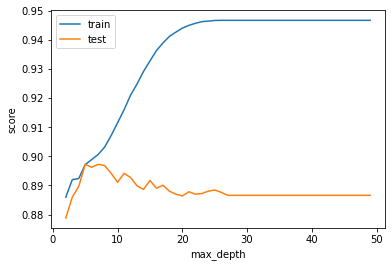

In [77]:
train_scores, test_scores = [],[]
for k in range(2,50):
    clf= DecisionTreeClassifier(criterion='entropy', splitter='best', 
                              max_depth=k, random_state=42) 
    clf.fit(X_train,y_train)
    train_scores.append(clf.score(X_train, y_train))
    test_scores.append(clf.score(X_test, y_test))
plt.plot(range(2,50), train_scores)
plt.plot(range(2,50), test_scores)
plt.legend(['train','test'])
plt.xlabel('max_depth')
plt.ylabel('score')
plt.show()

from the graph we can see that the best max_depth value is from this range- (2,10) so in the best_estimator_dt function we will choose 
the max_depth value option to be in this range

#### Build best estimator of decision tree classifier:

In [78]:
def best_estimator_dt(iteration, X_train, y_train):
    dt = DecisionTreeClassifier(random_state=42) 
    criterion = ['entropy','gini']

    max_depth = [int(x) for x in range(2,10)]
    max_depth.append(None)

    max_features = [None,'auto', 'log2', 2, 5, 8]

    max_leaf_nodes=[None,10,20,30,40,50,60,70,80,90] 

    min_samples_leaf = [1, 2, 5, 10,20,30]

    min_samples_split = [1, 2, 5, 10, 15, 20,30,40]

    min_weight_fraction_leaf=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]


    parameters = {'criterion': criterion,
                   'max_depth': max_depth,
                   'max_features': max_features,
                   'max_leaf_nodes': max_leaf_nodes,
                   'min_samples_leaf': min_samples_leaf,
                   'min_weight_fraction_leaf': min_weight_fraction_leaf,
                   'min_samples_split': min_samples_split}
    dt_random = RandomizedSearchCV(estimator = dt, param_distributions = parameters, n_iter = iteration, cv = 5,
                               verbose = 2, random_state = 42, n_jobs = -1)

    dt_random.fit(X_train,y_train)
    param= dt_random.best_params_
    #deals with none option
    if param['max_features']==None:
        max_features=[None,'auto',11]
    else:
        max_features=[param['max_features']+i for i in range(-1,2)]
        
    if param['max_leaf_nodes']==None:
        max_leaf_nodes=[None,95,100]
    else:
        max_leaf_nodes=[param['max_leaf_nodes']+5*i for i in range(-1,2)]
        
    if param['max_depth']==None:
        max_depth=[None,25,30]
    else:
        max_depth=[param['max_depth']+i for i in range(-1,2)]
        
    param_grid = {'criterion': [param['criterion']],
                   'max_depth': max_depth,
                   'max_features': max_features,
                   'max_leaf_nodes': max_leaf_nodes,
                   'min_samples_leaf': [param['min_samples_leaf']+i for i in range(-1,2)],
                   'min_weight_fraction_leaf': [param['min_weight_fraction_leaf']+0.1*i for i in range(-1,2)],
                   'min_samples_split': [param['min_samples_split']+i for i in range(-1,2)]}


    grid_search = GridSearchCV(estimator = dt, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_


In [79]:
clf_decision_tree=best_estimator_dt(1000, X_train, y_train)
clf_decision_tree.get_params()


Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 576 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 1388 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 3980 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  1.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 729 candidates, totalling 3645 fits


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 576 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 1388 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done 3638 out of 3645 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 3645 out of 3645 | elapsed:  1.1min finished


{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': 65,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 42,
 'splitter': 'best'}

In [80]:
clf_list.append(clf_decision_tree)

In [81]:
print_clf(clf_decision_tree,X_test, y_test)

confusion matrix:


0    1
0  4189   96
1   405  186

accuracy:  0.8972518457752255
precision: 0.6595744680851063


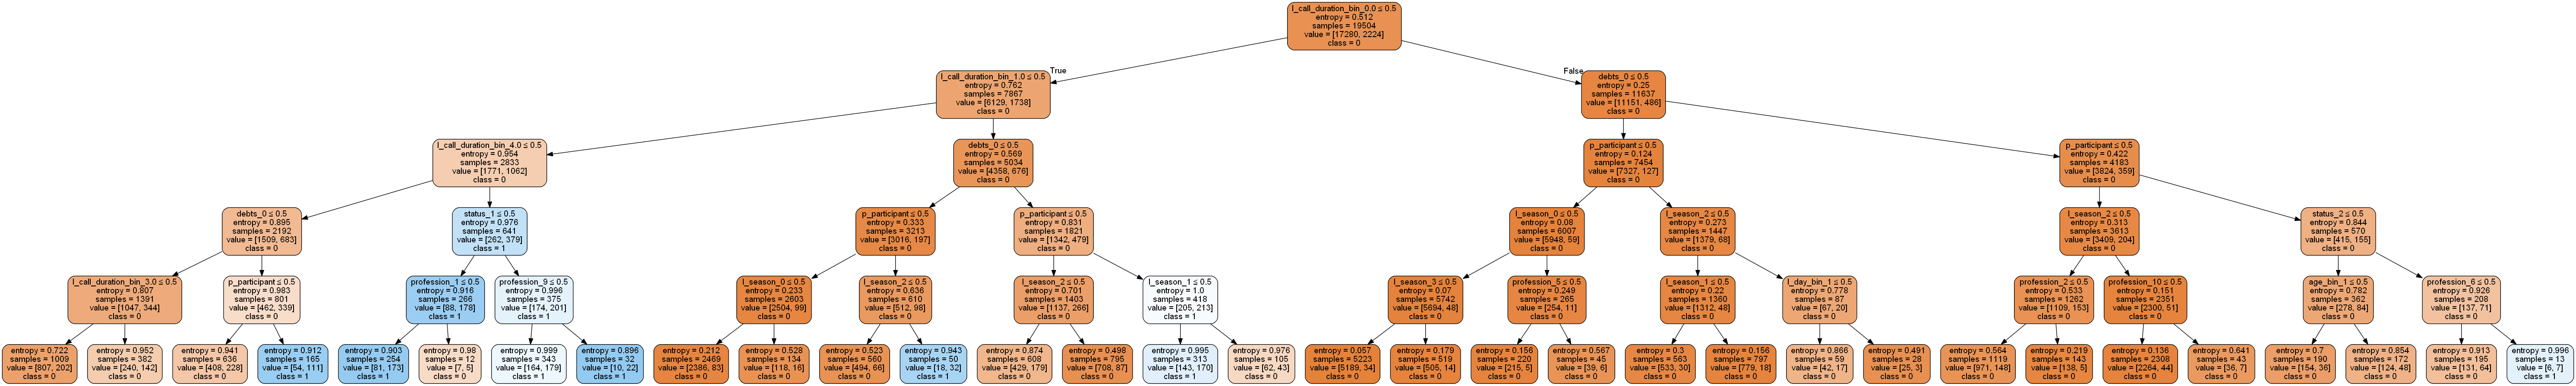

In [82]:
dot = export_graphviz(clf_decision_tree, filled=True, rounded=True, 
                special_characters=True,feature_names = X.columns,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot)  
graph.write_png('decision_tree.png')
Image(graph.create_png())

In [83]:
cm_dict_dt_best, acc_dict_dt_best, prec_dict_dt_best = mod_cv(clf_decision_tree, X, y)

------ 1 ------
Accuracy:  0.8972518457752255
------ 2 ------
Accuracy:  0.8941755537325676
------ 3 ------
Accuracy:  0.8974569319114027
------ 4 ------
Accuracy:  0.8904840032813782
------ 5 ------
Accuracy:  0.8988925348646432


In [84]:
model_option_dict[list(acc_dict_dt_best.keys())[0]] = list(acc_dict_dt_best.values())[0]

### Random Forest Classifier

* data evaluation on __Random Forest Classifier__

In [85]:
cm_dict_rf, acc_dict_rf, prec_dict_rf = data_cv(data_option_dict, RandomForestClassifier(random_state = 42))

In [86]:
best_data_option = ttest_find_best(acc_dict_rf)
best_data_option

'data_norm_and_not_with_debts'

In [87]:
X =  data_option_dict[best_data_option].drop(['subscribed'], axis=1)
y =  data_option_dict[best_data_option]['subscribed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True) 

we find best features from the best data for best classification:

In [88]:
from sklearn.feature_selection import RFECV

# The "accuracy" scoring is proportional to the number of correct classifications
clf_rf = RandomForestClassifier(random_state = 42) 
rfecv = RFECV(estimator=clf_rf, step=1, cv=5,scoring='accuracy') 
rfecv = rfecv.fit(X_train, y_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train.columns[rfecv.support_])

Optimal number of features : 10
Best features : Index(['status', 'profession', 'debts', 'p_participant', 'l_season',
       'l_call_duration_z_norm', 'account_balance_z_norm', 'n_contact_z_norm',
       'age_z_norm', 'l_day_z_norm'],
      dtype='object')


In [89]:
X=X[['status', 'profession', 'debts', 'p_participant', 'l_season',
       'l_call_duration_z_norm', 'account_balance_z_norm', 'n_contact_z_norm',
       'age_z_norm', 'l_day_z_norm']].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True) 

#### Build best estimator of random forest classifier:

In [92]:
def best_estimator_rf(iteration, X_train, y_train):

    rf = RandomForestClassifier(random_state = 42)

    n_estimators = [int(x) for x in np.linspace(start = 1, stop = 300, num = 20)]

    max_features = ['auto', 'log2']

    max_depth = [int(x) for x in np.linspace(5, 50, num = 10)]
    max_depth.append(None)

    min_samples_split = [None,2, 5, 10,15,20]

    min_samples_leaf = [1,3, 5, 10]
    bootstrap = [True, False]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = iteration, cv = 5,
                                   verbose = 2, random_state = 42, n_jobs = -1,scoring='accuracy')

    rf_random.fit(X_train, y_train)
    param= rf_random.best_params_

    if param['max_depth']==None:
        max_depth=[None]
    else:
         max_depth=[param['max_depth']+2*i for i in range(-1,2)]
            
    if param['min_samples_leaf']==1:
        min_samples_leaf=[1,2,3]
    else:
         min_samples_leaf=[param['min_samples_leaf']+2*i for i in range(-1,2)]

    param_grid = {'n_estimators': [param['n_estimators']+8*i for i in range(-1,2)],
                   'max_depth': max_depth,
                   'max_features': [param['max_features']],
                   'min_samples_leaf':min_samples_leaf,
                   'bootstrap':[param['bootstrap']],
                   'min_samples_split': [param['min_samples_split']+i for i in range(-1,2)]}
    grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2,scoring='accuracy')
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_

In [94]:
clf_random_forest=best_estimator_rf(500, X_train, y_train)
clf_random_forest.get_params()

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   59.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 22.1min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 31.0min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 42.6min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed: 52.6min finished


Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:  6.4min finished


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 20,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 5,
 'min_samples_split': 15,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 111,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [95]:
clf_list.append(clf_random_forest)

In [96]:
print_clf(clf_random_forest,X_test, y_test)

confusion matrix:


0    1
0  4203   82
1   426  165

accuracy:  0.8958162428219852
precision: 0.6680161943319838


In [97]:
cm_dict_rf_best, acc_dict_rf_best, prec_dict_rf_best = mod_cv(clf_random_forest, X, y)

------ 1 ------
Accuracy:  0.8960213289581624
------ 2 ------
Accuracy:  0.8964315012305168
------ 3 ------
Accuracy:  0.9007383100902379
------ 4 ------
Accuracy:  0.8943806398687448
------ 5 ------
Accuracy:  0.8972518457752255


In [98]:
model_option_dict[list(acc_dict_rf_best.keys())[0]] = list(acc_dict_rf_best.values())[0]

### Visualizing One Tree in the Forest

In [99]:
tree = clf_random_forest.estimators_[10]

In [100]:
dot = export_graphviz(tree, filled=True, rounded=True, 
                special_characters=True,feature_names = X.columns,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot)  
graph.write_png('tree_10_in_forest.png')
Image(graph.create_png())

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.862675 to fit

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.862675 to fit



## CatBoost Classification 


* data evaluation on __CatBoost Classifier__

In [101]:
cm_dict_cb, acc_dict_cb, prec_dict_cb = data_cv(data_option_dict, CatBoostClassifier(one_hot_max_size=11,logging_level='Silent'))

In [102]:
best_data_option = ttest_find_best(acc_dict_cb)

In [103]:
best_data_option

'data_cat_with_debts_dummies'

In [104]:
X =  data_option_dict[best_data_option].drop(['subscribed'], axis=1)
y =  data_option_dict[best_data_option]['subscribed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True) 

In [105]:
col_cat = [col for col in X_train.columns if (col.find('z_norm') == -1)]

 see how a iterations parameter affect the performances, in the <b> train </b> and in the <b> test </b>:

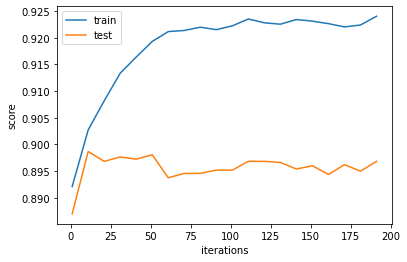

In [135]:
train_scores, test_scores = [],[]
for k in range(1,200,10):
    clf_cat_boost = CatBoostClassifier(iterations=k, one_hot_max_size=2,verbose = False)
    clf_cat_boost.fit(X_train,y_train, cat_features=col_cat)
    train_scores.append(clf_cat_boost.score(X_train, y_train))
    test_scores.append(clf_cat_boost.score(X_test, y_test))
plt.plot(range(1,200,10),train_scores)
plt.plot(range(1,200,10),test_scores)
plt.legend(['train','test'])
plt.xlabel('iterations')
plt.ylabel('score')
plt.show()

#### Build best estimator of random forest classifier:

In [107]:
def best_estimator_cb(iteration,X_train,y_train):
    cb=CatBoostClassifier(one_hot_max_size=2, logging_level='Silent')

    iterations=np.arange(2, 31,2).tolist()
    
    depth = [2,4,6,8,10,12,14]

    learning_rate=np.arange(0.05, 0.55,0.03).tolist()
    
    l2_leaf_reg= [1, 3, 5, 7, 9]
        
        
    grow_policy=['SymmetricTree','Depthwise','Lossguide']
    
    boosting_type =["Ordered", "Plain"]
    loss_function=['Logloss','MultiClass']

    parameters = {'iterations':iterations,
                    'boosting_type':boosting_type,
                    'l2_leaf_reg': l2_leaf_reg,
                    'depth': depth,
                    'learning_rate': learning_rate,
                    'loss_function':loss_function,
                    'grow_policy': grow_policy}
    cb_random = RandomizedSearchCV(estimator = cb, param_distributions = parameters, n_iter = iteration, cv = 5,
                               verbose = 2, random_state = 42, n_jobs = -1)

    cb_random.fit(X_train,y_train, cat_features=col_cat)
    param= cb_random.best_params_


    param_grid = {'iterations': [param['iterations']+i for i in range(-1,2)],
                   'boosting_type':[param['boosting_type']],
                   'depth': [param['depth']+i for i in range(-1,2)],
                   'learning_rate': [param['learning_rate']+0.015*i for i in range(-1,2)],
                   'l2_leaf_reg':[param['l2_leaf_reg']+i for i in range(-1,2)],
                   'loss_function':[param['loss_function']],
                   'grow_policy': [param['grow_policy']]}
    grid_search = GridSearchCV(estimator = cb, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2,scoring='accuracy')
    grid_search.fit(X_train,y_train, cat_features=col_cat)
   
    return cb_random.best_estimator_

In [108]:
clf_cat_boost=best_estimator_cb(600,X_train,y_train)
clf_cat_boost.get_params()

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 24.3min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 36.0min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 50.8min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 65.0min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 76.7min finished


Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed: 15.1min finished


{'iterations': 26,
 'learning_rate': 0.35,
 'depth': 6,
 'l2_leaf_reg': 5,
 'loss_function': 'MultiClass',
 'logging_level': 'Silent',
 'one_hot_max_size': 2,
 'boosting_type': 'Ordered',
 'grow_policy': 'SymmetricTree'}

In [109]:
print_clf(clf_cat_boost,X_test, y_test)

confusion matrix:


0    1
0  4192   93
1   408  183

accuracy:  0.8972518457752255
precision: 0.6630434782608695


In [110]:
clf_list.append(clf_cat_boost)

In [111]:
cm_dict_cat_best, acc_dict_cat_best, prec_dict_cat_best = mod_cv(clf_cat_boost, X, y)

------ 1 ------
Accuracy:  0.8980721903199343
------ 2 ------
Accuracy:  0.8978671041837571
------ 3 ------
Accuracy:  0.9021739130434783
------ 4 ------
Accuracy:  0.8931501230516817
------ 5 ------
Accuracy:  0.9017637407711239


In [112]:
model_option_dict[list(acc_dict_cat_best.keys())[0]] = list(acc_dict_cat_best.values())[0]

# Model evaluation 

#### Comparison between the list of different types of data on spesific classifier:

In [115]:
clf_list

[XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=0.5, eval_metric='logloss',
               gamma=0, gpu_id=-1, importance_type='gain',
               interaction_constraints='', learning_rate=0.1, max_delta_step=0,
               max_depth=3, min_child_weight=6, missing=nan,
               monotone_constraints='()', n_estimators=500, n_jobs=4,
               num_parallel_tree=1, objective='reg:squarederror', random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
               tree_method='exact', use_label_encoder=False,
               validate_parameters=1, verbosity=None),
 MLPClassifier(activation='tanh', alpha=0.05, hidden_layer_sizes=(50, 100, 50),
               learning_rate='adaptive'),
 BaggingClassifier(base_estimator=SVC(C=1, gamma=0.1, kernel='poly',
                                      probability=True),
                   max_samples=0.2, n_estimators=20, n_jo

In [118]:
model_option_dict

{'XGBClassifier': [0.8960213289581624,
  0.8935602953240361,
  0.8972518457752255,
  0.8890484003281378,
  0.899712879409352],
 'MLPClassifier': [0.8974569319114027,
  0.8954060705496308,
  0.8941755537325676,
  0.8913043478260869,
  0.8968416735028713],
 'Bagging With SVMClassifier': [0.8923297785069729,
  0.8947908121410992,
  0.8937653814602133,
  0.8874077112387203,
  0.9021739130434783],
 'GaussianNB': [0.882895816242822,
  0.8910992616899097,
  0.889253486464315,
  0.8894585726004922,
  0.8908941755537325],
 'DecisionTreeClassifier': [0.8972518457752255,
  0.8941755537325676,
  0.8974569319114027,
  0.8904840032813782,
  0.8988925348646432],
 'RandomForestClassifier': [0.8960213289581624,
  0.8964315012305168,
  0.9007383100902379,
  0.8943806398687448,
  0.8972518457752255],
 'CatBoostClassifier': [0.8980721903199343,
  0.8978671041837571,
  0.9021739130434783,
  0.8931501230516817,
  0.9017637407711239]}

In [119]:
best_model=ttest_find_best(model_option_dict)

In [120]:
best_model

'CatBoostClassifier'

In [121]:
best_clf = [clf_list[i] for i in range(0,len(clf_list)) if clf_list[i].__class__.__name__==best_model]

In [122]:
best_clf

### check overfitting according the validation data:

get the best data that we found before for the best model :

In [123]:
X =  data_cat_with_debts_dummies.drop(['subscribed'], axis=1)
y =  data_cat_with_debts_dummies['subscribed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True) 

In [124]:
X_valid=valid_cat_with_debts_dummies.drop(['subscribed'], axis=1)
y_valid=valid_cat_with_debts_dummies['subscribed']

train:
 accuracy: 0.9015586546349467 
 precision: 0.696113074204947
cm:
       0    1
0  4199   86
1   394  197
validation:
 accuracy: 0.901048492791612 
 precision: 0.6344086021505376
cm:
       0    1
0  5264  136
1   468  236


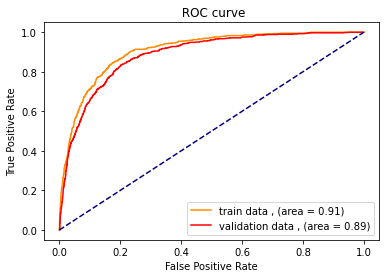

In [125]:
roc_curve(best_clf[0],X_test,y_test,X_valid,y_valid)

# Test Prediction:
create CSV file with a predictions for the attached test data set:</br>
the test file "marketing_campaigns_test_pre_processing_part1.csv" is the test data after pre-processing (we did the tet pre-process in notebook part1).</br>
As we saw the 'catboost' was the best classifier with data option 'data_cat_with_debts_dummies'. 
* first we transform the test data features to be the same as  data_cat_with_debts_dummies features
*we apply clf_cat_boost on the test data
* we save the predict lable in csv

In [126]:
test = pd.read_csv("./marketing_campaigns_test_pre_processing_part1.csv")

In [127]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14694 entries, 0 to 14693
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      14694 non-null  int64  
 1   status                  14694 non-null  int64  
 2   education               14694 non-null  int64  
 3   profession              14694 non-null  int64  
 4   device                  14694 non-null  int64  
 5   loan                    14694 non-null  int64  
 6   mortgage                14694 non-null  int64  
 7   credit                  14694 non-null  int64  
 8   positive                14694 non-null  int64  
 9   l_season                14694 non-null  int64  
 10  p_participant           14694 non-null  int64  
 11  debts                   14694 non-null  int64  
 12  age_z_norm              14694 non-null  float64
 13  account_balance_z_norm  14694 non-null  float64
 14  n_contact_z_norm        14694 non-null

In [128]:
test_cat_with_debts = test[['status', 'profession', 'device', 'debts', 'p_participant', 'l_season', 
                              'l_call_duration_bin', 'l_day_bin', 'account_balance_bin', 'age_bin', 'n_contact_bin']].copy()
test_cat_with_debts_dummies = divide_to_dummies(test_cat_with_debts.copy())
test_cat_with_debts_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14694 entries, 0 to 14693
Data columns (total 40 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   device                   14694 non-null  int64
 1   p_participant            14694 non-null  int64
 2   n_contact_bin            14694 non-null  int64
 3   status_0                 14694 non-null  uint8
 4   status_1                 14694 non-null  uint8
 5   status_2                 14694 non-null  uint8
 6   profession_0             14694 non-null  uint8
 7   profession_1             14694 non-null  uint8
 8   profession_2             14694 non-null  uint8
 9   profession_3             14694 non-null  uint8
 10  profession_4             14694 non-null  uint8
 11  profession_5             14694 non-null  uint8
 12  profession_6             14694 non-null  uint8
 13  profession_7             14694 non-null  uint8
 14  profession_8             14694 non-null  uint8
 15  pr

In [129]:
y_predict_test=best_clf[0].predict(test_cat_with_debts_dummies)

In [130]:
y_predict_test

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int64)

In [131]:
test['subscribed-predict']=np.reshape(y_predict_test, len(y_predict_test))

In [132]:
test['subscribed-predict'].value_counts()

0    13771
1      923
Name: subscribed-predict, dtype: int64

In [134]:
test.to_csv('test_prediction.csv')